### Final Capstone Project 3_Hotel Reviews Sentiment Analysis

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Additional Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
### Fixed Variables ###
randstate = 91

In [4]:
# Load in CSV and preview
hoteldf = pd.read_csv("Hotel_Reviews.csv", index_col=0)
hoteldf.head()

,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
Hotel_Address,,,,,,,,,,,,,,,,
s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


### NLP Section

# TEXT PREPARATION AND DATA CLEANING

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ["hotel", "hotels", "everything", "could", "would", "the", "and", "were", "are", "is", "was", "a", "very", "positive", "negative"]  # to add on more stopwords

In [6]:
# Top Positive Comments
hoteldf[(hoteldf["Average_Score"] >= 8.8) & (hoteldf["Positive_Review"] != "No Positive")]["Positive_Review"]

Hotel_Address
1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom     They have followed through special requests C...
1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom     Great location and very comfortable rooms Roo...
1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom     We had the most basic room which was great va...
1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom     Standard rooms are very comfortable Good cent...
1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom     Very large room Hidden courtyard view with ba...
                                                                                                       ...                        
Wilton Place Knightsbridge Westminster Borough London SW1X 7RL United Kingdom     personolized and high class service ar all level
Wilton Place Knightsbridge Westminster Borough London SW1X 7RL United

In [7]:
# Declaring those with scores more than 8.8 as Positive Reviews
X = hoteldf[(hoteldf["Average_Score"] >= 8.8) & (hoteldf["Positive_Review"] != "No Positive")]["Positive_Review"]
y = hoteldf[(hoteldf["Average_Score"] >= 8.8) & (hoteldf["Positive_Review"] != "No Positive")]["Reviewer_Score"]

In [8]:
cvec = CountVectorizer(stop_words = stop, lowercase=True)
X1 = cvec.fit_transform(X)
sum_words = X1.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [9]:
genposcount = pd.DataFrame(words_freq, columns=["word", "count"]).head(10)

In [10]:
# Declaring that those below 8.1 have negative reviews.
X = hoteldf[(hoteldf["Average_Score"] <= 8.1) & (hoteldf["Negative_Review"] != "No Negative")]["Negative_Review"]
y = hoteldf[(hoteldf["Average_Score"] <= 8.1) & (hoteldf["Negative_Review"] != "No Negative")]["Reviewer_Score"]

In [11]:
cvec = CountVectorizer(stop_words = stop, lowercase=True)
X1 = cvec.fit_transform(X)
sum_words = X1.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [12]:
gennegcount = pd.DataFrame(words_freq, columns=["word", "count"]).head(10)

In [13]:
pd.concat([genposcount, gennegcount], axis=1)

,word,count,word,count
0,staff,63823,room,70744
1,location,49716,small,21722
2,room,42000,breakfast,18864
3,great,35609,rooms,14992
4,friendly,26604,staff,14933
5,good,24780,bed,12795
6,helpful,23740,bathroom,10931
7,breakfast,22773,one,10266
8,excellent,21242,night,9022
9,nice,19085,bit,8698


### Attempting to classify if Review is Positive or Negative

In [14]:
# Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import WordNetLemmatizer
from sklearn.pipeline import Pipeline
import seaborn as sns

In [15]:
# Set a copy of hoteldf for processing of Positive Reviews
df1 = hoteldf.copy()

# Create the is_positive column with 0s
df1["is_positive"] = 0

# Create a list of strings indicating no positive review
neg_strings = ["no positive", "nothing", "nothing at all"]

# Set is_positive to 1 where reviews are not in the neg_strings list
df1["is_positive"] = (~df1["Positive_Review"].str.lower().isin(neg_strings)).astype(int)

# Filter the DataFrame based on the conditions
df1 = df1[(df1["Average_Score"] > 8.8) & (df1["is_positive"] == 1)][["Positive_Review", "is_positive"]].reset_index(drop=True)

# Rename the columns
df1.columns = ["Review", "is_positive"]


In [16]:
# Set a copy of hoteldf for processing of Negative Reviews
df2 = hoteldf.copy()

# Create the is_positive column with 1s initially
df2["is_positive"] = 1

# Create a list of strings that indicate no negative review
pos_strings = ["no negative"]

# Set is_positive to 0 where reviews are not in the pos_strings list
df2["is_positive"] = df2["Negative_Review"].str.lower().isin(pos_strings).astype(int)

# Adjust cases where "nothing" or variations indicate no negative review
nothing_strings = ["nothing", "nothing at all"]
df2.loc[df2["Negative_Review"].str.lower().isin(nothing_strings), "is_positive"] = 1

# Filter the DataFrame based on the conditions
df2 = df2[(df2["Average_Score"] < 8.1) & (df2["is_positive"] == 0)][["Negative_Review", "is_positive"]].reset_index(drop=True)

# Rename the columns
df2.columns = ["Review", "is_positive"]


In [17]:
nndf = pd.concat([df1, df2]).reset_index(drop=True)

In [18]:
nndf.sample(8)

,Review,is_positive
35700,absolutely everything about this wonderful ho...,1
95301,Staff were great Old worldly atmosphere with ...,1
194671,The Wifi was not good enough to receive data ...,0
180982,The lift didn t work the 3 night we was there...,0
66862,Very helpful and extremely friendly staff Exc...,1
137625,Pictures looks 5 times better This is not wha...,0
91706,Great location friendly clean helpful staff f...,1
143165,The lift is always not operating,0


In [19]:
# Combined df1 & df2 for NLP Review classification
nlpdf = pd.concat([df1, df2]).reset_index(drop=True)

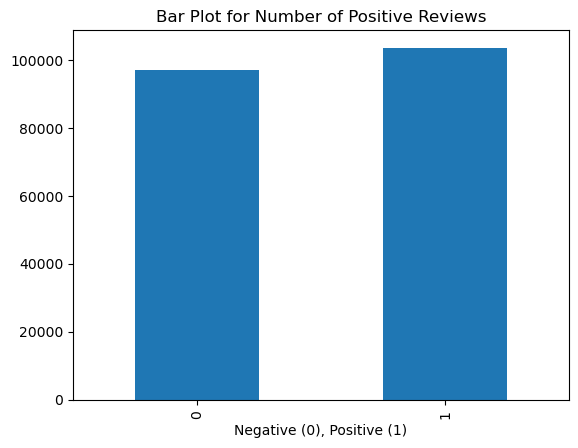

In [20]:
# Plot to check if there is class imbalance
nlpdf["is_positive"].value_counts().sort_values().plot.bar()
plt.title("Bar Plot for Number of Positive Reviews")
plt.xlabel("Negative (0), Positive (1)")
plt.show()

In [21]:
baseline = nlpdf["is_positive"].value_counts()[1] / nlpdf["is_positive"].value_counts().sum()

In [22]:
# Lemmy all the nouns to simple forms
trial1 = []
lemmatizer = WordNetLemmatizer()
for item in nlpdf["Review"]:
    trial1.append(" ".join([lemmatizer.lemmatize(i) for i in item.lower().split()]))

In [23]:
# Replacing Review with lemmatized words
nlpdf["Review"] = trial1
nlpdf["length"] = nlpdf["Review"].apply(lambda x: len(x.split(" ")))
nlpdf

,Review,is_positive,length
0,they have followed through special request com...,1,15
1,great location and very comfortable room room ...,1,22
2,we had the most basic room which wa great valu...,1,16
3,standard room are very comfortable good centra...,1,8
4,very large room hidden courtyard view with bac...,1,24
...,...,...,...
200604,breakfast satisfactory but boring,0,4
200605,internet should never ever be payable in a hotel,0,9
200606,room a little small but adequate,0,6
200607,the room wasn t what wa described on website t...,0,22


In [24]:
import scipy.stats as stats

In [25]:
nlpdf[nlpdf["length"] == 4]["Review"]

5               location and room excellent
49                    location of the hotel
77                       room and comfy bed
401                     room size and style
415        brilliant hotel perfect location
                        ...                
200553                nothing it wa perfect
200562                 no laundry on sunday
200595                  small room no frill
200600                   room wa very small
200604    breakfast satisfactory but boring
Name: Review, Length: 9554, dtype: object

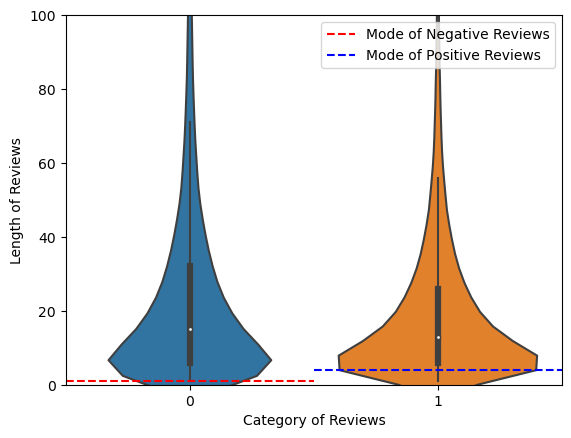

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Violin plot for review lengths
sns.violinplot(x="is_positive", y="length", data=nlpdf)
plt.xlabel("Category of Reviews")
plt.ylabel("Length of Reviews")

# Get lengths where is_positive == 0 and == 1
neg_lengths = nlpdf[nlpdf["is_positive"] == 0]["length"]
pos_lengths = nlpdf[nlpdf["is_positive"] == 1]["length"]

# Calculate the mode for the 'length' where is_positive == 0
if len(neg_lengths) > 0:
    mode_neg = stats.mode(neg_lengths, keepdims=False).mode
    if mode_neg.size > 0:  # Check if the mode exists
        plt.axhline(mode_neg, xmax=0.5, c="r", ls="--", label="Mode of Negative Reviews")
    else:
        print("No mode found for negative reviews.")
else:
    print("No negative reviews found.")

# Calculate the mode for the 'length' where is_positive == 1
if len(pos_lengths) > 0:
    mode_pos = stats.mode(pos_lengths, keepdims=False).mode
    if mode_pos.size > 0:  # Check if the mode exists
        plt.axhline(mode_pos, xmin=0.5, c="b", ls="--", label="Mode of Positive Reviews")
    else:
        print("No mode found for positive reviews.")
else:
    print("No positive reviews found.")

# Set the y-axis limits and show the plot
plt.ylim(0, 100)
plt.legend()
plt.show()


In [27]:
# Using VADER to analyse
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
from sklearn.metrics import roc_curve, auc  

In [28]:
X = nndf["Review"]
y = nndf["is_positive"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify=y, random_state=randstate)

In [29]:
# Special function to categorize if Positive or Negative for VADER
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    #print(sentence, snt)
    if snt["neg"] > snt["pos"]:
        tl.append(0)
    elif snt["pos"] > snt["neg"]:
        tl.append(1)
    else:
        if snt["compound"] < 0:
            tl.append(0)
        else:
            tl.append(1)

In [30]:
tl = []
for x in X_test2:
    print_sentiment_scores(x)

In [31]:
tp = 0
fp = 0
tn = 0
fn = 0

for z in range(0, len(y_test2)):
    if (tl[z] == 0) and (y_test2.tolist()[z] == 0): #TN
        tn += 1
    elif (tl[z] == 1) and (y_test2.tolist()[z] == 0): #FP
        fp += 1
    elif (tl[z] == 0) and (y_test2.tolist()[z] == 1): #FN
        fn += 1
    elif (tl[z] == 1) and (y_test2.tolist()[z] == 1): #TP
        tp += 1
print("TP", tp, "TN", tn, "FP", fp, "FN", fn)

TP 25671 TN 10681 FP 13579 FN 222


In [32]:
vd_pred = pd.Series(tl, index=y_test2.index)

In [33]:
vdr_score = roc_auc_score(vd_pred, y_test2)

In [34]:
X = nlpdf["Review"]
y = nlpdf["is_positive"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state=randstate)

In [36]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, stop_words=stop, ngram_range=(1, 2), strip_accents = 'unicode')),
    ('tfidf', TfidfTransformer())
])
cvec = pipeline.get_params()["vect"]

In [37]:
X_train1 = pipeline.fit_transform(X_train)
X_test1 = pipeline.transform(X_test)

In [38]:
# Multinomial Naive Bayes
mnd = MultinomialNB()
mnd.fit(X_train1, y_train)
y_pred = mnd.predict(X_test1)
ymnd = mnd.predict_proba(X_test1)
mnb_score = roc_auc_score(y_test, y_pred)
mnb_score

0.9410702114241288

In [39]:
# RandomForest Classifier
rfc = RandomForestClassifier(random_state=randstate, n_jobs=3)
rfc.fit(X_train1, y_train)
y_pred = rfc.predict(X_test1)
yrfc = rfc.predict_proba(X_test1)
rfc_score = roc_auc_score(y_test, y_pred)
rfc_score

0.9402285919468065

In [40]:
# Logistic Regression
lr = LogisticRegression(random_state=randstate)
lr.fit(X_train1, y_train)
y_pred = lr.predict(X_test1)
ylr = lr.predict_proba(X_test1)
lr_score = roc_auc_score(y_test, y_pred)
lr_score

0.9434522023767971

In [41]:
cross_val_score(lr, X_train1, y_train, scoring ='roc_auc', cv=5).mean()

0.9826262600538899

In [42]:
# GridSearch Parameters for Logistic Regression
parameters = {"penalty": ["l1", "l2"],
              "C": np.logspace(-1,1,20)}
gs = GridSearchCV(lr, parameters, verbose=1, cv=3)
gs.fit(X_train1, y_train)
y_pred = gs.best_estimator_.predict(X_test1)
ylrgs = gs.best_estimator_.predict_proba(X_test1)
lrgs_score = roc_auc_score(y_test, y_pred)
lrgs_score

Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solve

0.9454033143726903

In [43]:
pd.DataFrame({"Tests": ["Baseline", "VADER", "Multinomial", "Random Forest", "Logistic Regression", "Logistic (GridSearch)"],
              "Score": [baseline, vdr_score, mnb_score, rfc_score, lr_score, lrgs_score]})

,Tests,Score
0,Baseline,0.516273
1,VADER,0.816838
2,Multinomial,0.941070
3,Random Forest,0.940229
4,Logistic Regression,0.943452
5,Logistic (GridSearch),0.945403


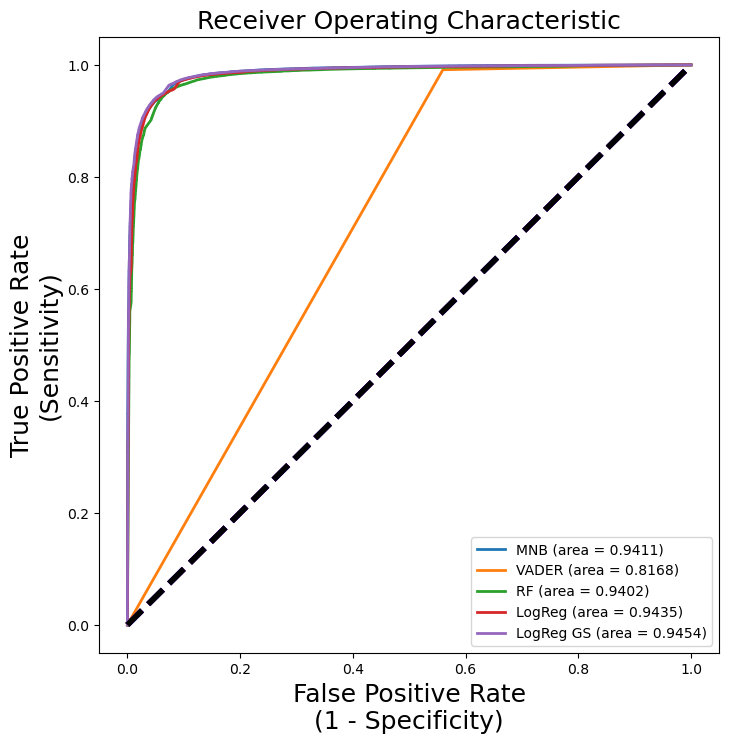

In [44]:
# Plot of a ROC curve for class 1 (has_cancer).
plt.figure(figsize=[8,8])

plt.plot([0, 1], [0, 1], 'c--', linewidth=4)
fpr, tpr, _ = roc_curve(y_test, ymnd[:,1])
plt.plot(fpr, tpr, label='MNB (area = %0.4f)' % mnb_score, linewidth=2)

plt.plot([0, 1], [0, 1], 'g--', linewidth=4)
fpr, tpr, _ = roc_curve(y_test2, vd_pred)
plt.plot(fpr, tpr, label='VADER (area = %0.4f)' % vdr_score, linewidth=2)

plt.plot([0, 1], [0, 1], 'm--', linewidth=4)
fpr, tpr, _ = roc_curve(y_test, yrfc[:,1])
plt.plot(fpr, tpr, label='RF (area = %0.4f)' % rfc_score, linewidth=2)

plt.plot([0, 1], [0, 1], 'r--', linewidth=4)
fpr, tpr, _ = roc_curve(y_test, ylr[:,1])
plt.plot(fpr, tpr, label='LogReg (area = %0.4f)' % lr_score, linewidth=2)

plt.plot([0, 1], [0, 1], 'b--', linewidth=4)
fpr, tpr, _ = roc_curve(y_test, ylrgs[:,1])
plt.plot(fpr, tpr, label='LogReg GS (area = %0.4f)' % lrgs_score, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate\n(1 - Specificity)', fontsize=18)
plt.ylabel('True Positive Rate\n(Sensitivity)', fontsize=18)
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
confusion_matrix(y_test, y_pred)

array([[46208,  2312],
       [ 3187, 48598]], dtype=int64)

In [47]:
recall = confusion_matrix(y_test, y_pred)[0][0] / (confusion_matrix(y_test, y_pred)[0][0] + confusion_matrix(y_test, y_pred)[0][1])
recall

0.9523495465787304

In [48]:
precision = confusion_matrix(y_test, y_pred)[0][0] / (confusion_matrix(y_test, y_pred)[0][0] + confusion_matrix(y_test, y_pred)[1][0])
precision

0.9354792995242434

In [49]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [50]:
recall_score(y_test, y_pred)

0.9384570821666506

In [51]:
precision_score(y_test, y_pred)

0.9545865252406207

In [52]:
f1_score(y_test, y_pred, average="micro")

0.9451772095109915

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     48520
           1       0.95      0.94      0.95     51785

    accuracy                           0.95    100305
   macro avg       0.95      0.95      0.95    100305
weighted avg       0.95      0.95      0.95    100305



<Axes: ylabel='word'>

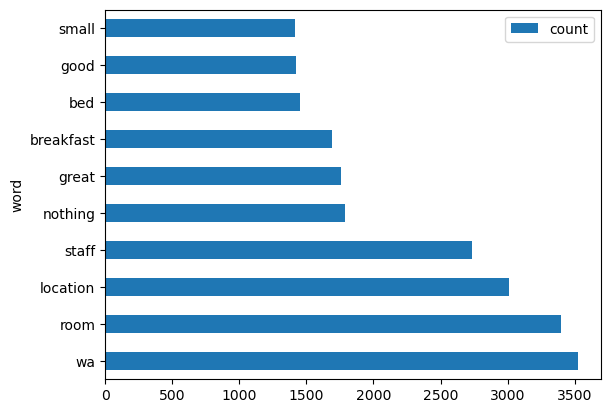

In [54]:
# Get the importance of words in reviews
sum_words = X_test1.sum(axis=0)
cvec = pipeline.get_params()["vect"]
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
# Importance of words in both reviews
pd.DataFrame(words_freq, columns=["word", "count"]).head(10).set_index("word").plot.barh()

In [55]:
import re

In [56]:
# Output Tester
def detector(text):
    text = re.sub('[^a-z\s]', '', text.lower())
    text = [" ".join([lemmatizer.lemmatize(i.lower()) for i in text.split()])]
    text = pipeline.transform(text)
    print(lr.predict_proba(text)[0])
    if lr.predict(text)[0] > 0:
        print("Positive Comment!")
    else:
        print("Negative Comment!")

In [57]:
detector("the hotel is very far away, cannot wait for the bus.")

[0.97626919 0.02373081]
Negative Comment!


In [58]:
detector("hotel is not very clean, but interesting")

[0.19532298 0.80467702]
Positive Comment!


In [59]:
detector("Easy to reach Covent Garden Soho and City. However the hotel is quite far away from Westminster. Room is clean comfy and nicely designed. Very nice couch good bath.")

[0.10145948 0.89854052]
Positive Comment!


In [60]:
tttfff = ["the room is small but clean", "joker is fun and happy"]

In [61]:
for i in tttfff:
    detector(i)

[0.96908926 0.03091074]
Negative Comment!
[0.27705925 0.72294075]
Positive Comment!


### Trying out Keyword Extractor

In [63]:
# Sample text
text = ["This breakfast is not good to eat, poor chef"]

# Apply lemmatization
text = [" ".join([lemmatizer.lemmatize(i.lower()) for i in text[0].split()])]

# Transform the text using your pipeline (assuming pipeline includes a TfidfVectorizer)
tf_idf_vector = pipeline.transform(text)

# Get feature names using 'get_feature_names_out()'
feature_names = pipeline.get_params()["vect"].get_feature_names_out()

# Display the vector and the corresponding feature names
print("TF-IDF Vector:", tf_idf_vector.toarray())
print("Feature Names:", feature_names)


TF-IDF Vector: [[0. 0. 0. ... 0. 0. 0.]]
Feature Names: ['00' '00 00' '00 00am' ... 'zzzzz jacuzzi' 'zzzzzzzzzzzz'
 'zzzzzzzzzzzz really']


In [64]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    
    """
    Extract the feature names and TF-IDF scores of Top n items.
       
    
    """
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [65]:
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
 
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\n=====Doc=====")
print(text[0])
print("\n===Keywords===")
for k in keywords:
    print(k, keywords[k], end=" | ")


=====Doc=====
this breakfast is not good to eat, poor chef

===Keywords===
poor chef 0.559 | good eat 0.526 | chef 0.374 | breakfast good 0.305 | eat 0.291 | poor 0.223 | good 0.155 | breakfast 0.139 | 

In [68]:
from sklearn.feature_selection import chi2
from joblib import Parallel, delayed
import numpy as np

# Set N as the number of top features to consider
N = 100  # You can adjust N to balance between performance and speed

# Get the feature names using 'get_feature_names_out' for modern scikit-learn
feature_names = np.array(pipeline.get_params()["vect"].get_feature_names_out())

# Perform chi-squared feature selection
features_chi2, p_values = chi2(features, labels)

# Get the top N features based on the chi-squared score
top_indices = np.argsort(features_chi2)[-N:]

# Define a function to process each feature
def process_feature(idx):
    word = feature_names[idx]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    return word, unigrams[-N:], bigrams[-N:]

# Parallel processing of top N features using joblib for faster computation
results = Parallel(n_jobs=-1)(delayed(process_feature)(idx) for idx in top_indices)

# Print the results for each feature
for word, unigrams, bigrams in results:
    print(f"# '{word}':")
    print(f"  . Most correlated unigrams: {', '.join(unigrams)}")
    print(f"  . Most correlated bigrams: {', '.join(bigrams)}")


# 'night':
  . Most correlated unigrams: yoiung, yoke, yolk, yoni, yoo, york, yorkie, yorkish, yorkshire, youd, youghurs, youghurt, yougurts, youll, youncheck, young, younger, youngest, youngster, youre, youselves, yout, youth, youthful, youtube, yoy, yoyrcstaff, ypu, yr, yricados, yu, yuck, yuk, yuki, yulia, yum, yummie, yummier, yummies, yummy, yuo, yur, yuri, yuroi, zaak, zafirovski, zaft, zag, zakynthos, zany, zara, zealand, zealous, zen, zenpark, zentrum, zero, zest, zetland, zetter, zeytoon, zi, zieglergasse, zig, zigadome, ziggo, ziggodome, zijn, zilch, zin, zinc, zince, zink, zip, ziplock, zipped, zipper, zizzi, zo, zobblers, zoe, zolt, zona, zone, zoo, zoom, zoomed, zore, zparos, zsba, ztaff, zucchini, zuid, zuidas, zuiver, zur, zusje, zzzound, zzzzz, zzzzzzzzzzzz
  . Most correlated bigrams: zero wifi, zest wa, zetland arm, zetter peaceful, zetter pleasant, zetter staff, zetter wedding, zeytoon road, zi returned, zi wa, zieglergasse u3, zig zag, ziggo concert, ziggo dome, zig

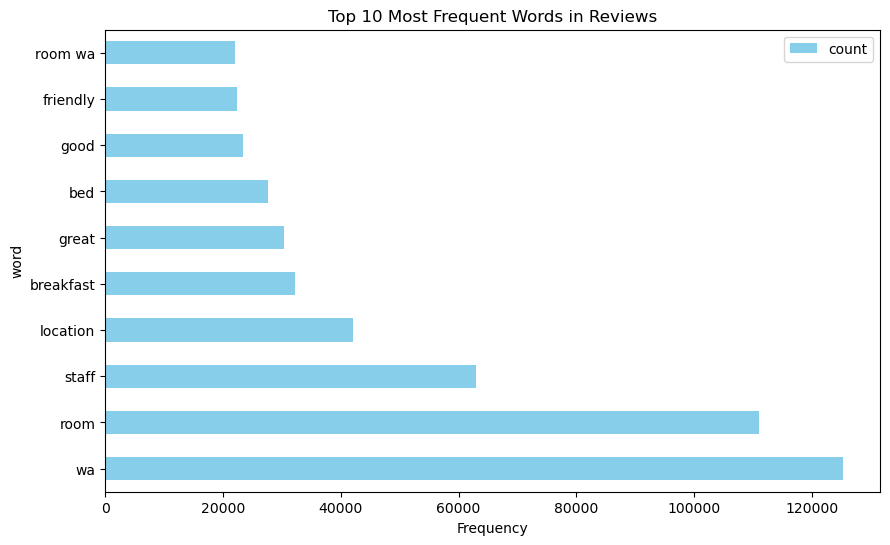

In [73]:
# Get the transformed test data from the vectorizer
X_test_transformed = pipeline.named_steps['vect'].transform(nlpdf['Review'])

# Convert the sparse matrix to a dense array
sum_words = np.array(X_test_transformed.sum(axis=0)).flatten()

# Retrieve the CountVectorizer from the pipeline
cvec = pipeline.get_params()["vect"]

# Create a list of (word, count) pairs
words_freq = [(word, sum_words[idx]) for word, idx in cvec.vocabulary_.items() if idx < len(sum_words)]

# Sort the list of words by frequency in descending order
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Create a DataFrame for visualization
top_words_freq_df = pd.DataFrame(words_freq[:10], columns=["word", "count"])

# Plot the top 10 most frequent words
top_words_freq_df.set_index("word").plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title("Top 10 Most Frequent Words in Reviews")
plt.xlabel("Frequency")
plt.show()


### Recommender System Portion

In [74]:
# Imports
import gzip
import gensim
from textblob import TextBlob

In [75]:
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [76]:
nlpdf['text_sentiment'] = nlpdf["Review"].apply(sentiment)

In [77]:
# Positive Reviews
doc = nlpdf.loc[nlpdf[nlpdf["is_positive"] == 1].index, "Review"].apply(lambda x: TextBlob(x.lower()).words)
# Negative Reviews
doc2 = nlpdf.loc[nlpdf[nlpdf["is_positive"] == 0].index, "Review"].apply(lambda x: TextBlob(x.lower()).words)

In [79]:
model1 = gensim.models.Word2Vec(doc, vector_size=150, window=10, min_count=2, workers=10)
model1.train(doc, total_examples=len(doc), epochs=10)

model2 = gensim.models.Word2Vec(doc2, vector_size=150, window=10, min_count=2, workers=10)
model2.train(doc2, total_examples=len(doc2), epochs=10)


(17849003, 25510890)

In [80]:
# Identifying words that are related to w1 under Positive Reviews
w1 = ["bedroom"]
model1.wv.most_similar(positive=w1,topn=15)

[('room', 0.6759052276611328),
 ('sink', 0.5058870911598206),
 ('roomy', 0.5030413269996643),
 ('apartment', 0.501524031162262),
 ('wardrobe', 0.4968971908092499),
 ('bright', 0.47285106778144836),
 ('closet', 0.4650806188583374),
 ('toilet', 0.4621186852455139),
 ('separate', 0.4456224739551544),
 ('heating', 0.43554937839508057),
 ('tub', 0.4295642673969269),
 ('couch', 0.4287799000740051),
 ('chair', 0.4233165383338928),
 ('bed', 0.42298275232315063),
 ('underfloor', 0.42077523469924927)]

In [81]:
# Identifying words that are related to w1 under Negative Reviews
model2.wv.most_similar(positive=w1,topn=15)

[('room', 0.6519376039505005),
 ('bathroom', 0.4917494058609009),
 ('ensuite', 0.4467068910598755),
 ('cupboard', 0.44329914450645447),
 ('wardrobe', 0.432742714881897),
 ('pane', 0.4234919846057892),
 ('hallway', 0.42192569375038147),
 ('crack', 0.4157801866531372),
 ('pokey', 0.41412273049354553),
 ('stairwell', 0.4134572148323059),
 ('squashed', 0.40910178422927856),
 ('tape', 0.40633586049079895),
 ('patch', 0.39981135725975037),
 ('squeezed', 0.3995325267314911),
 ('foyer', 0.3973294198513031)]

In [83]:
w2c = dict()
for item in model1.wv.key_to_index:  # Use key_to_index instead of vocab
    w2c[item] = model1.wv.get_vecattr(item, 'count')  # Use get_vecattr to get the word count


In [84]:
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
w2cSorted

{'the': 133659,
 'and': 108872,
 'wa': 54068,
 'staff': 51248,
 'a': 50439,
 'very': 45136,
 'room': 43518,
 'to': 43108,
 'location': 38978,
 'hotel': 36094,
 'in': 31787,
 'of': 28681,
 'great': 28257,
 'is': 25399,
 'were': 23020,
 'friendly': 21050,
 'for': 20451,
 'we': 19184,
 'helpful': 18637,
 'with': 18231,
 'good': 18089,
 'breakfast': 18028,
 'excellent': 16919,
 'i': 16178,
 'it': 15330,
 'bed': 14936,
 'nice': 14283,
 'comfortable': 14006,
 'clean': 12452,
 'from': 10126,
 'all': 10094,
 'stay': 9617,
 'at': 9602,
 'lovely': 9478,
 'our': 9448,
 'everything': 9112,
 'are': 9089,
 'service': 9088,
 'on': 8921,
 'you': 8778,
 'this': 8353,
 'amazing': 8015,
 'so': 7651,
 'perfect': 7518,
 'but': 7223,
 'bar': 7219,
 'really': 7094,
 'had': 7018,
 'restaurant': 6627,
 'well': 6518,
 'my': 6289,
 'view': 5698,
 'have': 5682,
 'not': 5541,
 'fantastic': 5434,
 'they': 5398,
 'beautiful': 5395,
 'u': 5241,
 'that': 5239,
 'modern': 5166,
 'quiet': 5162,
 'would': 5040,
 'there':

### Using Hotel Name to identify specific features

In [85]:
hotelname_var = "Ritz Paris"

In [86]:
df3 = hoteldf[hoteldf["Hotel_Name"] == hotelname_var][["Negative_Review", "Positive_Review"]]
df3

,Negative_Review,Positive_Review
Hotel_Address,,
15 Place Vend me 1st arr 75001 Paris France,We had one odd moment when an attendant enter...,There is not much to stay about the Ritz It s...
15 Place Vend me 1st arr 75001 Paris France,View may not good Looking to your neighbor Fo...,Everying is perfect Beautiful hotel very nice...
15 Place Vend me 1st arr 75001 Paris France,No Negative,Absolutely amazing hotel Friendly and extraor...
15 Place Vend me 1st arr 75001 Paris France,Difficult to get a seat when you feel like go...,Everything Service staff superbly trained and...
15 Place Vend me 1st arr 75001 Paris France,Can t find anything,The staff and the property will make you feel...
15 Place Vend me 1st arr 75001 Paris France,Prices are exorbitant My husband found it all...,It s the Ritz in Paris and looks feels and ac...
15 Place Vend me 1st arr 75001 Paris France,In most five star hotels I usually have at le...,Stayed to celebrate our first anniversary and...
15 Place Vend me 1st arr 75001 Paris France,No Negative,Stayed at the Ritz to celebrate our recent we...
15 Place Vend me 1st arr 75001 Paris France,very expensive but DELIVERS,this is fantasy we ask the staff for transpor...


In [87]:
negdoc = df3["Negative_Review"].apply(lambda x: TextBlob(x.lower()).words)
posdoc = df3["Positive_Review"].apply(lambda x: TextBlob(x.lower()).words)

In [88]:
# extracting all keywords
negtext = [[w for w in TextBlob(x.lower()).words if w not in stop] for x in df3["Negative_Review"]]

In [90]:
model3 = gensim.models.Word2Vec(negdoc, vector_size=100, window=5, min_count=2, workers=10)
model3.train(negtext, total_examples=len(negdoc), epochs=10)


(177, 1370)

In [91]:
w1 = ["room"]
model3.wv.most_similar(positive=w1,topn=15)

[('when', 0.3086324632167816),
 ('no', 0.20083196461200714),
 ('seat', 0.20026305317878723),
 ('and', 0.18810324370861053),
 ('two', 0.17441536486148834),
 ('walk', 0.16733083128929138),
 ('i', 0.16575531661510468),
 ('he', 0.1462358981370926),
 ('have', 0.14444810152053833),
 ('not', 0.1295151263475418),
 ('hotel', 0.1239628717303276),
 ('was', 0.1210382953286171),
 ('but', 0.09246588498353958),
 ('be', 0.08862948417663574),
 ('your', 0.08432487398386002)]

### Using WordCloud to present comments

In [92]:
from wordcloud import WordCloud
import re
from matplotlib.ticker import FormatStrFormatter

In [93]:
def preprocess(x):
    
    '''
    Processes a string to remove any special characters & transforming to lowercase.
    
    Keyword arguments:
    x  --  Text String
    
    '''
    
    x = re.sub('[^a-z\s]', '', x.lower()) # get rid of noise
    x = [w for w in x.split() if w not in set(stop)] # remove stopwords
    return ' '.join(x) # then join the text again

In [94]:
def freq_words(document):
    sum_words = cvec.transform(document).sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [95]:
def takeSecond(elem):
    return elem[1]

In [96]:
# Function to check reviews of specific hotel
def wordcloud_hotel(hotelname_var, displaycount=False):
    
    '''
    Generates two WordClouds for a specific Hotel, consisting of Negative Keywords and Positive Keywords.
    
    Keyword arguments:
    hotelname_var  --  insert Hotel Name as String
    displaycount   -- displays Top 5 Keywords for both Negative and Positive reviews
    
    '''
    
    # limit scope of reviews
    df3 = hoteldf[hoteldf["Hotel_Name"] == hotelname_var][["Negative_Review", "Positive_Review"]]
    negdoc = df3["Negative_Review"].apply(preprocess)
    posdoc = df3["Positive_Review"].apply(preprocess)
    
    # declare our figure 
    plt.subplots(1, 2, figsize=(28,10))
    
    # Negative Words WordCloud
    plt.subplot(121, facecolor='yellow')
    # Generate WordCloud
    wc = WordCloud(width=1600, height=800, random_state=randstate, max_words=2000, background_color="white")
    wc.generate(str(negdoc))
    # add title to the graph
    plt.title("Negative Keywords about {}".format(hotelname_var), fontsize=30, color='black')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=10)

    # Positive Words WordCloud
    plt.subplot(122, facecolor='blue')
    wc = WordCloud(width=1600, height=800, random_state=randstate, max_words=2000, background_color="white")
    # Generate WordCloud
    wc.generate(str(posdoc))
    # Add Title
    plt.title("Positive Keywords about {}".format(hotelname_var), fontsize=30, color='black')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=2)
    plt.show()
    
    if displaycount == True:
        # Generate Keywords Frequency
        print("Top 5 Negative Words:", sorted(freq_words(negdoc), key=takeSecond, reverse=True)[0:5])
        print("Top 5 Positive Words:", sorted(freq_words(posdoc), key=takeSecond, reverse=True)[0:5])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6704\1139952097.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121, facecolor='yellow')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6704\1139952097.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122, facecolor='blue')


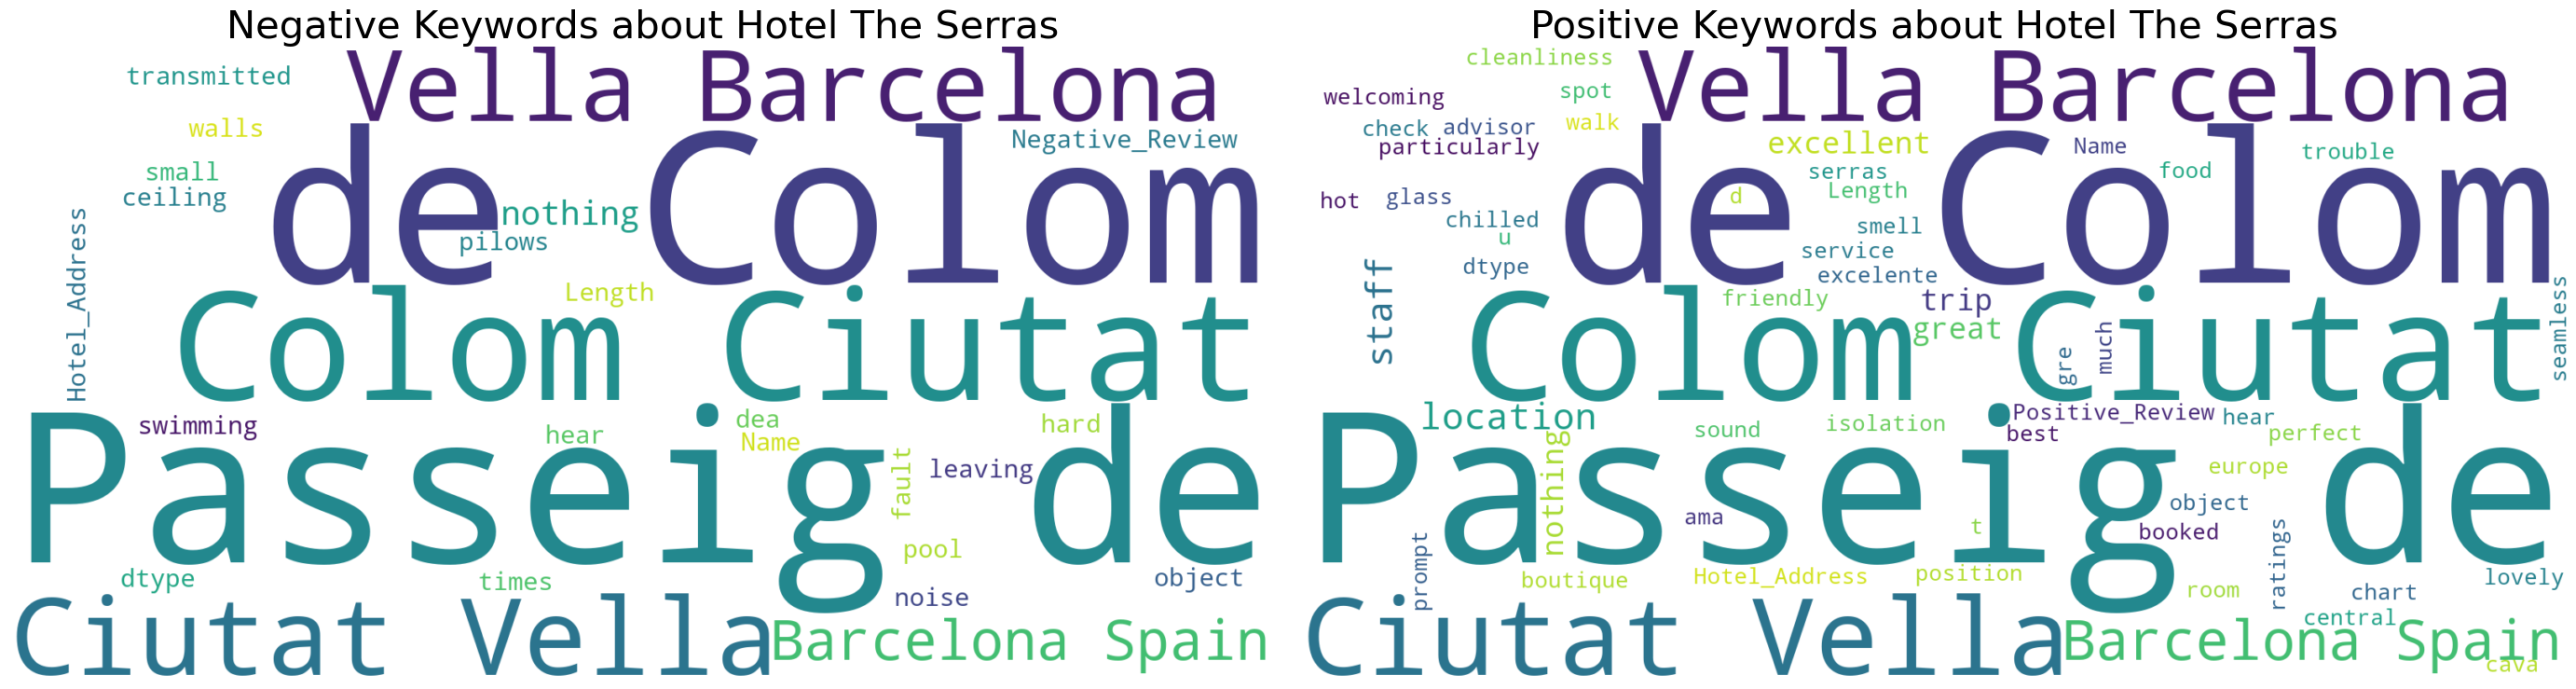

Top 5 Negative Words: [('nothing', 33), ('room', 26), ('small', 15), ('bit', 14), ('pool', 8)]
Top 5 Positive Words: [('staff', 150), ('location', 85), ('great', 80), ('excellent', 54), ('friendly', 49)]


In [97]:
wordcloud_hotel("Hotel The Serras", True)

In [106]:
# Function to check reviews of hotel in the state in general
def wordcloud_origin(origin_var, displaycount=False):
    
    '''
    Generates two WordClouds for reviews from a specific country, consisting of Negative Keywords and Positive Keywords.
    
    Keyword arguments:
    hotelstate_var  -- insert Country Name as String
    displaycount    -- displays Top 5 Keywords for both Negative and Positive reviews
    
    '''
    
    # Check if State is present in the data
    if origin_var.lower() not in hoteldf["Reviewer_Nationality"].apply(preprocess).unique():
        print("SelectionError: Please select from the following States -", " / ".join(hoteldf["Reviewer_Nationality"].apply(preprocess).unique().tolist()))
    else:
        # limit scope of reviews
        df3 = hoteldf[hoteldf["Reviewer_Nationality"].apply(preprocess) == origin_var.lower()][["Negative_Review", "Positive_Review"]]
        negdoc = df3["Negative_Review"].apply(preprocess)
        posdoc = df3["Positive_Review"].apply(preprocess)

        # declare our figure 
        plt.subplots(1, 2, figsize=(25,10))

        # Negative Words WordCloud
        plt.subplot(121, facecolor='yellow')
        # Generate WordCloud
        wc = WordCloud(width=1600, height=800, random_state=randstate, max_words=2000, background_color="white")
        wc.generate(str(negdoc))
        # add title to the graph
        plt.title("Negative Keywords by Guests from {}".format(origin_var.capitalize()), fontsize=30, color='black')
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout(pad=10)

        # Positive Words WordCloud
        plt.subplot(122, facecolor='blue')
        wc = WordCloud(width=1600, height=800, random_state=randstate, max_words=2000, background_color="white")
        # Generate WordCloud
        wc.generate(str(posdoc))
        # Add Title
        plt.title("Positive Keywords by Guests from {}".format(origin_var.capitalize()), fontsize=30, color='black')
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout(pad=4)
        plt.show()
        
        if displaycount == True:
            # Generate Keywords Frequency
            print("Top 5 Negative Words:", sorted(freq_words(negdoc), key=takeSecond, reverse=True)[0:5])
            print("Top 5 Positive Words:", sorted(freq_words(posdoc), key=takeSecond, reverse=True)[0:5])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6704\4089132542.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121, facecolor='yellow')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6704\4089132542.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122, facecolor='blue')


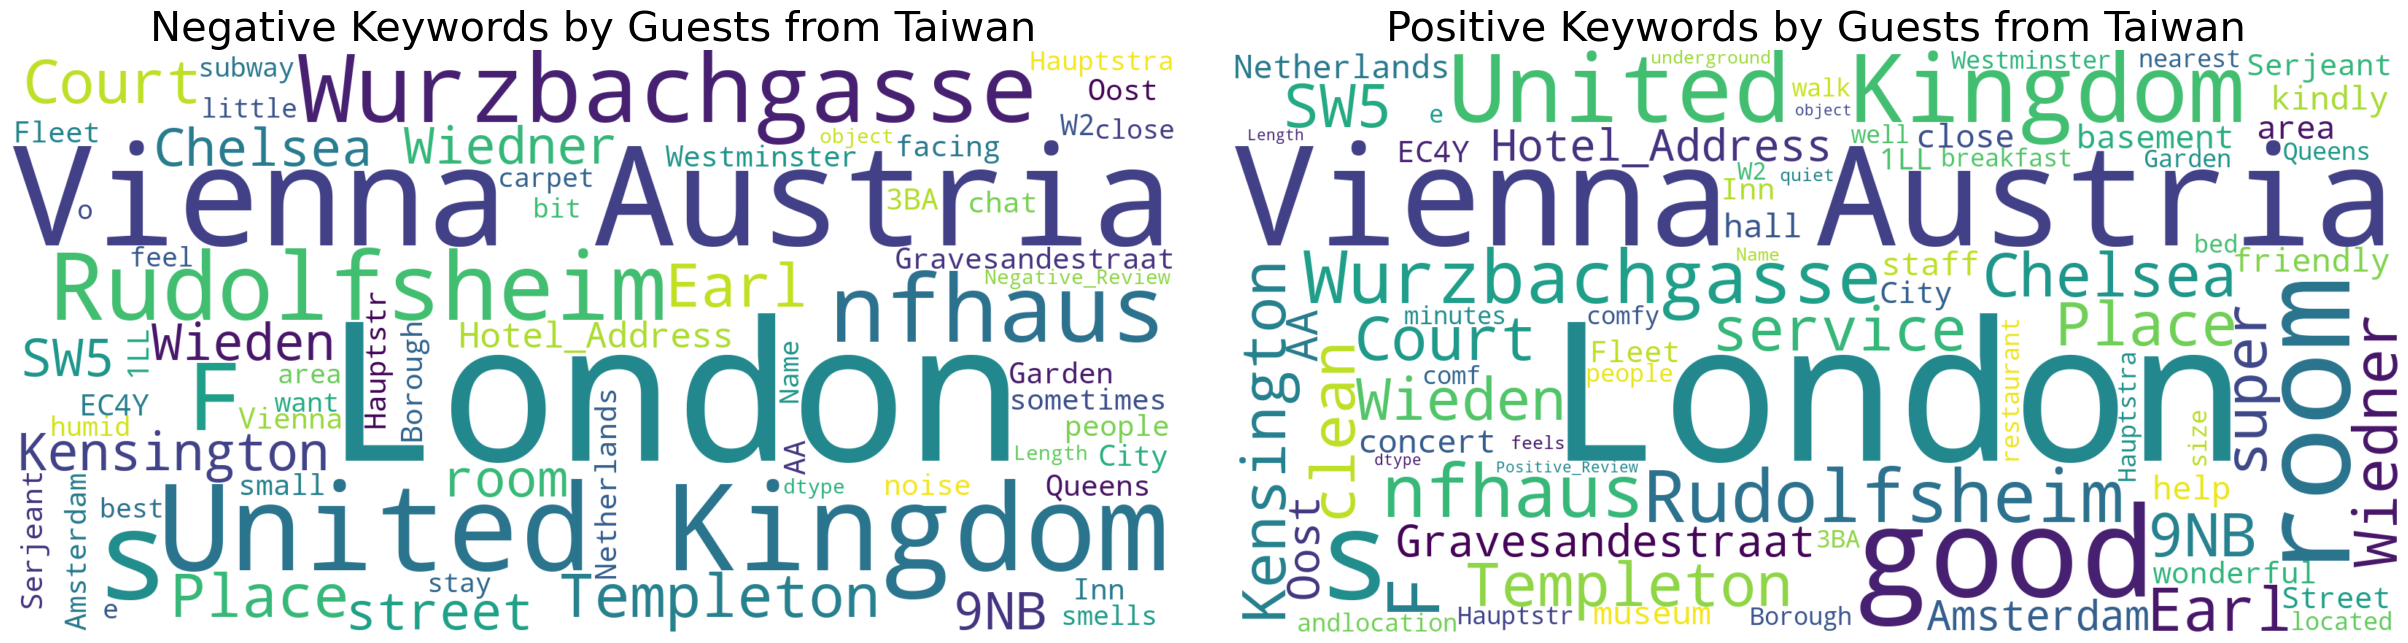

Top 5 Negative Words: [('room', 262), ('small', 75), ('breakfast', 56), ('water', 56), ('bit', 54)]
Top 5 Positive Words: [('location', 386), ('room', 264), ('good', 264), ('breakfast', 220), ('staff', 196)]


In [107]:
wordcloud_origin("Taiwan", True)

### Topic Modelling

In [108]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [112]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = pipeline.get_params()["vect"].get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 2

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(pipeline.get_params()["vect"].transform(negdoc))

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, pipeline.get_params()["vect"], number_words)


Topics found via LDA:

Topic #0:
fit king fit

Topic #1:
fine dining

Topic #2:
larger none

Topic #3:
help expensive

Topic #4:
none larger

Topic #5:
seat walk

Topic #6:
nothing star

Topic #7:
larger none

Topic #8:
bit attendant

Topic #9:
larger none


### Trying NMF

In [113]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [114]:
nmfsentences = [" ".join(text) for text in negdoc]

In [115]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000)
x_counts = vectorizer.fit_transform(negdoc)
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [118]:
# Obtain a NMF model
model = NMF(n_components=10, init='nndsvd')
model.fit(xtfidf_norm)

# Function to get NMF topics
def get_nmf_topics(model, n_top_words):
    # The word ids obtained need to be reverse-mapped to the words so we can print the topic names
    feat_names = vectorizer.get_feature_names_out()  # Updated to get_feature_names_out
    
    word_dict = {}
    for i in range(10):
        # For each topic, obtain the largest values, and add the words they map to into the dictionary
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

# Call the function to display the topics
n_top_words = 10
topics_df = get_nmf_topics(model, n_top_words)
print(topics_df)


  Topic # 01 Topic # 02 Topic # 03 Topic # 04 Topic # 05  Topic # 06  \
0   negative    nothing       none       find  breakfast       value   
1         no       here       your   anything         is       money   
2       view     hotels       good        can        bit         not   
3        the       five       here       view  expensive         for   
4        can        say       help        the       here          on   
5     triple     gripes         he     course        say        spot   
6      point    usually       have      point       five         fit   
7        pay      there        had   neighbor      there        king   
8     double      least     guests        pay     hotels  everything   
9       good         or     gripes      price    usually         the   

  Topic # 07 Topic # 08 Topic # 09 Topic # 10  
0      could     dining      noise   delivers  
1      rooms       fine     fridge       very  
2     larger   michelin     making        but  
3         be   

In [120]:
get_nmf_topics(model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,negative,nothing,none,find,breakfast,value,could,dining,noise,delivers
1,no,here,your,anything,is,money,rooms,fine,fridge,very
2,view,hotels,good,can,bit,not,larger,michelin,making,but
3,the,five,here,view,expensive,for,be,need,all,expensive
4,can,say,help,the,here,on,view,star,night,say
5,triple,gripes,he,course,say,spot,the,here,it,hotels
6,point,usually,have,point,five,fit,can,there,to,there
7,pay,there,had,neighbor,there,king,triple,least,he,five
8,double,least,guests,pay,hotels,everything,price,hotels,help,gripes
9,good,or,gripes,price,usually,the,course,usually,they,usually


# Submitted By- Shweta Kanungo (B-6)